# Quality Examination of approximation Quality

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GaussianMixtureNetwork as GMN
from plot_gaussian_mixture import *
import seaborn as sns

## Define Network Architecture and Input

In [2]:
np.random.seed(46)  # For reproducibility

#******Network Architecture******
layers = [1,10,10,10,1]
act_func = ['relu','relu','relu','linear']
gm_comp_pre = 2
gm_comp_post = 2
moments_pre = 5
moments_post = 5
a_relu = 0.0

x = np.array([[2.0]])   # Example input value

## Initialize Model and Run Forward

In [3]:
print("Initializing model...")
model = GMN.GaussianMixtureNetwork(layers,act_func,gm_comp_pre,gm_comp_post,moments_pre,moments_post,a_relu,peak=False)
print("Model initialized.")

print("Running forward pass...")
model.forward_combined(x)
print("Forward pass completed.")

Initializing model...
Gaussian Mixture Network Structure:
 Layer 0: 1 -> 10 neurons | Activation: relu
 Layer 1: 10 -> 10 neurons | Activation: relu
 Layer 2: 10 -> 10 neurons | Activation: relu
 Layer 3: 10 -> 1 neurons | Activation: linear
 Pre-activation GM components: 2, matched with 5 moments
 Post-activation GM components: 2, matched with 5 moments
 Leaky ReLU slope (a): 0.0
Model initialized.
Running forward pass...
Sampling weights for verification...
Sampling weights for verification done.
Forward pass completed.


## Result Overview
- Just looking at the output distribution and comparing different error measures


GM of the output
Means: [-23.03498641  51.07913459]
Variances: [2.07531556 8.98565897]
Weights: [0.55386473 0.44613527]


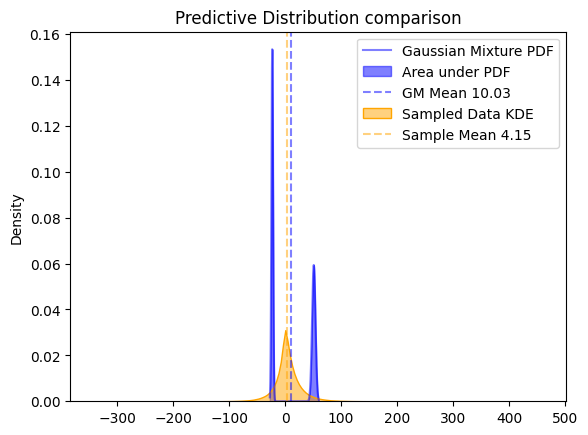

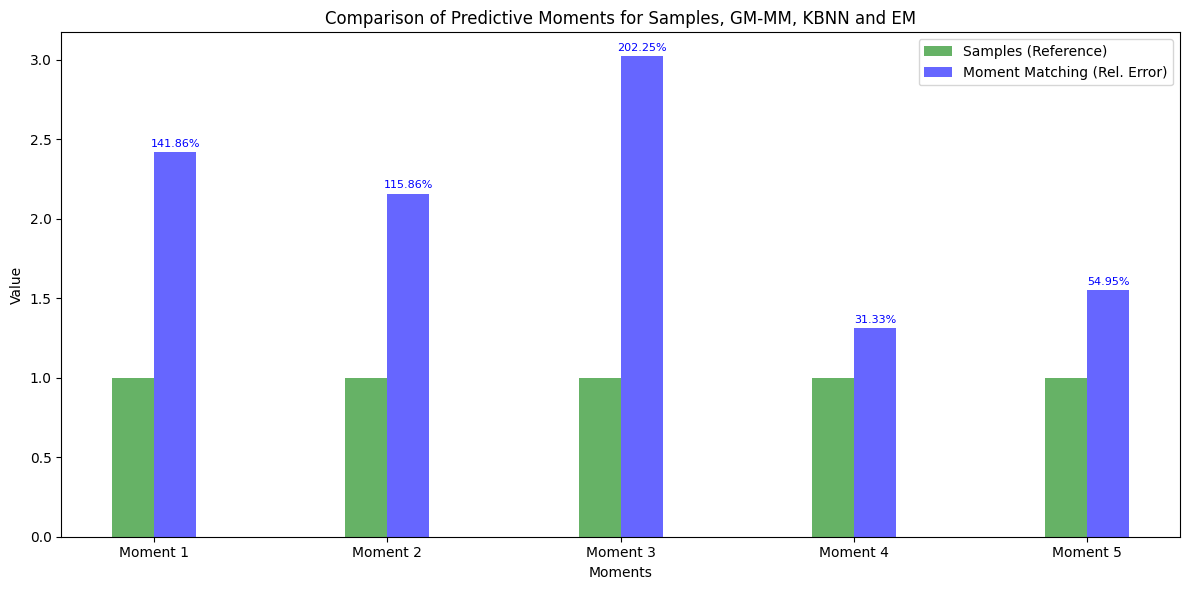

In [4]:
# Set the plotting rstuff for the GM
means = model.means_gm_post[-1][0,:]
variances = model.variances_gm_post[-1][0,:]
weights = model.weights_gm_post[-1][0,:]
x_min = np.min(means - 3 * np.sqrt(variances))
x_max = np.max(means + 3 * np.sqrt(variances))
x = np.linspace(x_min, x_max, 1000)

mean_gm = np.sum(weights * means)
var_gm = np.sum(weights * (variances + (means - mean_gm) ** 2))

print("GM of the output")
print("Means:", means)
print("Variances:", variances)
print("Weights:", weights)

# Set the plotting stuff for the samples
samples_end = model.post_activation_samples[-1][:,0]

mean_samples = np.mean(samples_end)
var_samples = np.var(samples_end)

alpha_glob = 0.5
plt.figure()
plt.title("Predictive Distribution comparison")
# Plot the Gaussian Mixture PDF
plt.plot(x, gaussian_mixture_pdf(x, weights, means, variances), label='Gaussian Mixture PDF', color='blue',alpha=alpha_glob)
plt.fill_between(x, gaussian_mixture_pdf(x, weights, means, variances), alpha=alpha_glob, color='blue', label='Area under PDF')
plt.axvline(mean_gm, color='blue', linestyle='--', label=f'GM Mean {mean_gm:.2f}', alpha=alpha_glob)
#for i in range(len(means)):
    #plt.plot(x, gaussian_pdf(x, means[i], np.sqrt(variances[i])), label=f'Component {i+1}', linestyle='--',alpha = 0.5,color='green')
# Plot the Sample-BAsed KDE
sns.kdeplot(samples_end, bw_adjust=1, fill=True, label='Sampled Data KDE', color='orange', alpha=alpha_glob)
plt.axvline(mean_samples, color='orange', linestyle='--', label=f'Sample Mean {mean_samples:.2f}', alpha=alpha_glob)
plt.legend()

# Output
predictive_moments_mm = []
for i in range(1, moments_post + 1):
    predictive_moments_mm.append(GMN.gm_noncentral_moment(i,model.weights_gm_post[-1][0,:],model.means_gm_post[-1][0,:],model.variances_gm_post[-1][0,:]))

predictive_moments_samples = []
for i in range(1, moments_post + 1):
    predictive_moments_samples.append(model.post_activation_moments_samples[-1][0,i-1])
    
# Compute the rel errors
relative_errors_mm_samples = []
relative_errors_em_samples = []
for i in range(moments_post):
    rel_error_mm_samples = 100 * abs((predictive_moments_mm[i] - predictive_moments_samples[i]) / predictive_moments_samples[i])
    relative_errors_mm_samples.append(rel_error_mm_samples)
    
#Error Bars
plt.figure(figsize=(12, 6))
x_labels = [f'Moment {i+1}' for i in range(moments_post)]
xl = np.arange(len(x_labels))  # the label locations
width = 0.18  # the width of the bars
bars_samples = plt.bar(xl - 0.5*width, np.ones_like(predictive_moments_samples), width, label='Samples (Reference)', color='green', alpha=0.6)
bars_mm = plt.bar(xl + 0.5*width, 1 + np.array(relative_errors_mm_samples)/100, width, label='Moment Matching (Rel. Error)', color='blue', alpha=0.6)
#bars_kbnn = plt.bar(x + 1.5*width, 1 + np.array(relative_errors_kbnn_samples)/100, width, label='KBNN', color='orange', alpha=0.6)

# Add relative error as text above each bar (except for samples, which is the reference)
for i in range(moments_post):
    plt.text(xl[i] + 0.5*width, 1 + relative_errors_mm_samples[i]/100 + 0.02, f"{relative_errors_mm_samples[i]:.2f}%", ha='center', va='bottom', fontsize=8, color='blue')
    #plt.text(x[i] + 0.5*width, 1 + rel_error_em_samples[i]/100 + 0.02, f"{rel_error_em_samples[i]:.2f}%", ha='center', va='bottom', fontsize=8, color='red')
    #plt.text(x[i] + 1.5*width, 1 + relative_errors_kbnn_samples[i]/100 + 0.02, f"{relative_errors_kbnn_samples[i]:.2f}%", ha='center', va='bottom', fontsize=8, color='orange')

plt.xlabel('Moments')
plt.ylabel('Value')
plt.title('Comparison of Predictive Moments for Samples, GM-MM, KBNN and EM')
plt.xticks(xl, x_labels)
plt.legend()
plt.tight_layout()

- Check the error metrics

In [5]:
print("Mean of the samples:", mean_samples)
print("Variance of the samples:", var_samples)

print("Mean of the GM:", mean_gm)
print("Variance of the GM:", var_gm)

print("First two moments of the GM")
print(model.post_activation_moments_analytic[-1][0,:2])
print("First two moments of the samples")
print(model.post_activation_moments_samples[-1][0,:2])

Mean of the samples: 4.146940492168379
Variance of the samples: 660.5829845784267
Mean of the GM: 10.029937178698997
Variance of the GM: 1362.4468393733432
First two moments of the GM
[   5.45728552 1118.6612338 ]
First two moments of the samples
[  4.14694049 677.78010002]


## Errors across the network


In [6]:
for i in range(len(model.layers)-1):
    for j in range(model.layers[i+1]):
        print(f"Layer {i}, Neuron {j}:")
        print("***PRE-ACTIVATION***")
        print(f"Analytic moments: {[f'{val:.2f}' for val in model.pre_activation_moments_analytic[i][j,:]]}")
        print(f"Sampled moments: {[f'{val:.2f}' for val in model.pre_activation_moments_samples[i][j,:]]}")
        rel_error = np.abs(model.pre_activation_moments_analytic[i][j,:] - model.pre_activation_moments_samples[i][j,:]) / np.where(model.pre_activation_moments_analytic[i][j,:] != 0, np.abs(model.pre_activation_moments_analytic[i][j,:]), 1)
        print(f"Rel. Error: {[f'{err*100:.2f}%' for err in rel_error]}")
        print("***POST-ACTIVATION***")
        print(f"Analytic moments: {[f'{val:.2f}' for val in model.post_activation_moments_analytic[i][j,:]]}")
        print(f"Sampled moments: {[f'{val:.2f}' for val in model.post_activation_moments_samples[i][j,:]]}")
        rel_error = np.abs(model.post_activation_moments_analytic[i][j,:] - model.post_activation_moments_samples[i][j,:]) / np.where(model.post_activation_moments_analytic[i][j,:] != 0, np.abs(model.post_activation_moments_analytic[i][j,:]), 1)
        print(f"Rel. Error: {[f'{err*100:.2f}%' for err in rel_error]}")


        


Layer 0, Neuron 0:
***PRE-ACTIVATION***
Analytic moments: ['0.58', '5.33', '8.82', '85.05', '225.45']
Sampled moments: ['0.57', '5.34', '8.84', '85.21', '225.53']
Rel. Error: ['0.17%', '0.20%', '0.18%', '0.19%', '0.03%']
***POST-ACTIVATION***
Analytic moments: ['1.29', '4.14', '15.59', '65.54', '299.84']
Sampled moments: ['1.21', '3.71', '14.25', '63.86', '321.51']
Rel. Error: ['6.29%', '10.34%', '8.57%', '2.57%', '7.23%']
Layer 0, Neuron 1:
***PRE-ACTIVATION***
Analytic moments: ['-0.15', '5.02', '-2.18', '75.63', '-54.69']
Sampled moments: ['-0.14', '5.02', '-2.18', '75.56', '-56.25']
Rel. Error: ['1.50%', '0.04%', '0.27%', '0.09%', '2.85%']
***POST-ACTIVATION***
Analytic moments: ['0.76', '1.40', '3.08', '7.71', '21.23']
Sampled moments: ['0.82', '2.25', '7.88', '32.53', '152.12']
Rel. Error: ['8.17%', '61.06%', '155.57%', '322.13%', '616.68%']
Layer 0, Neuron 2:
***PRE-ACTIVATION***
Analytic moments: ['-0.58', '5.33', '-8.82', '85.05', '-225.43']
Sampled moments: ['-0.58', '5.33', 